In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
from scipy import interpolate

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

# Constants

In [3]:
# List of atmoic numbers
A_dict = {'H' : 1.00797 ,
'He' : 4.00260 ,
'Li' : 6.941 ,
'Be' : 9.01218 ,
'B' : 10.81 ,
'C' : 12.011 ,
'N' : 14.0067 ,
'O' : 15.994 ,
'F' : 18.9994 ,
'Ne' : 20.179 ,
'Na' : 22.98977 ,
'Mg' : 24.305 ,
'Al' : 26.98154 ,
'Si' : 28.0855 ,
'P' : 30.97376 ,
'S' : 32.06 ,
'Cl' : 35.453 ,
'A' : 39.948 ,
'K' : 39.0983 ,
'Ca' : 40.08 ,
'Sc' : 44.9559 ,
'Ti' : 47.90 ,
'V' : 50.9415 ,
'Te' : 51.996 ,
'Mn' : 54.9380 ,
'Fe' : 55.847 ,
'Co' : 58.70 ,
'Ni' : 58.9332 ,
'Cu' : 63.546 ,
'Zn' : 65.38,
}

In [4]:
# Significance levels
# Sigma values taken from Gehrels 1986
cdf_1sig = 0.8413
cdf_2sig = 0.9772
cdf_3sig = 0.9987

In [5]:
# Boltzmann constant, adjusted to use km instead of m
k_B = 1.380649e-29
# Mass of hydrogen atom
amu = 1.66054e-27

# Functions

In [6]:
def gen_b(T, b_NT, A):
    
    return np.sqrt((2*k_B*T/(A*amu)) + b_NT**2)

In [7]:
def log_prior(params):

    # Grid parameters being varied
    T, b_NT = params
    
    # Avoid edges?
    if 1e+4<T<1e+6 and 0<b_NT<50:
        return 0.0
    return -np.inf

In [8]:
def log_likelihood(params, b_list):
    
    T, b_NT = params
    
    ll = 0
    
    for i in range(len(b_list)):
        
        ybar = gen_b(T, b_NT, A_dict[b_list[i][1]])
        y = b_list[i][2]
        dy = b_list[i][3]
        
        ll += -.5*(y-ybar)**2/dy**2
            
    return ll

In [9]:
def log_probability(params, b_list):
        
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, b_list)

In [10]:
gen_b(1e+4, 0, A_dict['H'])

12.844232700646511

In [11]:
gen_b(1e+4, 0, A_dict['C'])

3.7208519053703197

In [12]:
gen_b(1e+4, 0, A_dict['N'])

3.445593622658098

In [13]:
gen_b(1e+4, 0, A_dict['O'])

3.2244334848939453

In [14]:
gen_b(1e+4, 0, A_dict['Si'])

2.433273287255247

# z=0.67

In [15]:
b_list = [[['HI', 'H', 36, 2],
          ['CIII', 'C', 31, 2],
          ['CIV', 'C', 32, 5],
          ['OIII', 'O', 33, 2],
          ['OIV', 'O', 30, 2],
          ['OVI', 'O', 31, 3]
          ]]

In [17]:
pos = np.array([10**4.2, 32]) + 1e-4 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape

In [18]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(b_list)
)

In [19]:
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████████████████████████████████| 5000/5000 [00:16<00:00, 298.18it/s]


State([[2.19453296e+04 3.10295594e+01]
 [1.83485427e+04 3.11634935e+01]
 [1.95174586e+04 2.96175582e+01]
 [3.56869127e+04 3.02721308e+01]
 [2.12131330e+04 3.18398998e+01]
 [2.41870653e+04 3.13178842e+01]
 [2.48394643e+04 3.13909392e+01]
 [2.24265083e+04 3.21325831e+01]
 [2.85041341e+04 3.11126829e+01]
 [1.92018183e+04 2.93009291e+01]
 [3.61885384e+04 2.94454193e+01]
 [1.70280252e+04 3.14849370e+01]
 [2.72214902e+04 3.06226578e+01]
 [3.09719367e+04 2.97686444e+01]
 [1.01218344e+04 3.08359647e+01]
 [1.55548712e+04 3.15075205e+01]
 [1.15355608e+04 3.03542948e+01]
 [2.81735899e+04 2.88856401e+01]
 [2.08929351e+04 3.09274181e+01]
 [1.65933987e+04 3.21415708e+01]
 [1.77080784e+04 3.04825465e+01]
 [1.96624695e+04 3.09349936e+01]
 [2.94606308e+04 3.12634043e+01]
 [1.12530129e+04 3.25747828e+01]
 [1.27930219e+04 3.12327649e+01]
 [1.56891178e+04 3.09259775e+01]
 [3.21551698e+04 3.21858145e+01]
 [1.90529746e+04 3.16901717e+01]
 [1.19031849e+04 3.01508131e+01]
 [3.38437097e+04 3.16868222e+01]
 [1.

In [20]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=500, flat=True), 
                                columns=['T', 'b_NT'])

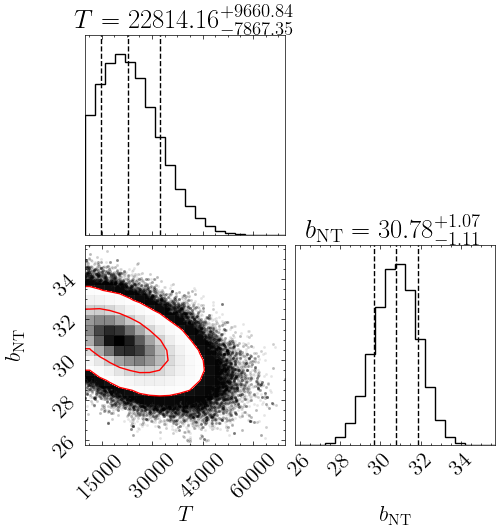

In [21]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$T$', r'$b_{\mathrm{NT}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [22]:
pdf, edges = np.histogram(flat_samples['T'], bins=100)
centers = .5*(edges[1:]+edges[:-1])
cdf = np.cumsum(pdf)/np.sum(pdf)
ppf = interpolate.interp1d(x=cdf, y=centers)

Text(0, 0.5, 'CDF')

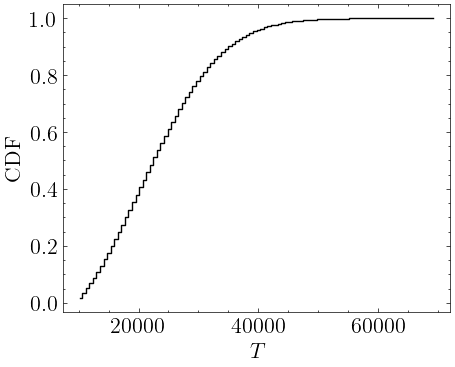

In [23]:
fig, ax = plt.subplots(1, figsize=(5,4))
ax.step(centers, cdf, where='mid')
ax.set_xlabel(r'$T$')
ax.set_ylabel('CDF')

In [24]:
np.log10(ppf(cdf_3sig))

4.732789972321521